<a href="https://colab.research.google.com/github/cds0987/Translation-RCNN/blob/main/BEST_TRANSLATION_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
file_path = "/content/drive/MyDrive/NLP_PJROJECT/vie.txt"

# Read the contents of the file
with open(file_path, "r") as file:
    file_contents = file.readlines()

In [2]:
import string

# Function to remove punctuation marks from a sentence
def remove_punctuation(sentence):
    return ''.join(char for char in sentence if char not in string.punctuation)


In [3]:
max_seq_length = 18

input_sentences = []
target_sentences = []
for line in file_contents:  # Print only the first pair for testing
    input_text, target_text, _ = line.strip().split('\t')
    input_text = remove_punctuation(input_text)
    target_text = remove_punctuation(target_text)
    input_sentences.append(input_text)
    target_sentences.append(target_text)


In [5]:
import matplotlib.pyplot as plt


In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [6]:
generation_signal = "<gen>"
eos_signal = "<eos>"
pad_token = "<pad>"

# Function to modify sentences
def modify_sentences(sentences):
    modified_sentences = []
    for sentence in sentences:
        # Append generation signal at the beginning and EOS signal at the end of the sentence
        modified_sentence = f"{generation_signal} {sentence} {eos_signal}"
        modified_sentences.append(modified_sentence)
    return modified_sentences

# Modify input sentences
modified_input_sentences = modify_sentences(input_sentences)

# Modify target sentences
modified_target_sentences = modify_sentences(target_sentences)

In [7]:
tokenizer_input = Tokenizer(filters='', oov_token='<unk>')
tokenizer_input.fit_on_texts(modified_input_sentences)
tokenizer_input.word_index[pad_token] = len(tokenizer_input.word_index) + 1
tokenizer_input.index_word[len(tokenizer_input.word_index)] = pad_token
input_sequences = tokenizer_input.texts_to_sequences(modified_input_sentences)


In [8]:
tokenizer_target = Tokenizer(filters='', oov_token='<unk>')
tokenizer_target.fit_on_texts(modified_target_sentences)
tokenizer_target.word_index[pad_token] = len(tokenizer_target.word_index) + 1
tokenizer_target.index_word[len(tokenizer_target.word_index)] = pad_token
target_sequences = tokenizer_target.texts_to_sequences(modified_target_sentences)

In [9]:
max_length = max(len(seq) for seq in input_sequences + target_sequences)
padded_input_sequences = pad_sequences(input_sequences, maxlen=18, padding='post', value=tokenizer_input.word_index[pad_token])
padded_target_sequences = pad_sequences(target_sequences, maxlen=18, padding='post', value=tokenizer_target.word_index[pad_token])

In [10]:
print("First Padded Input Sequence:")
print(padded_input_sequences[17])


First Padded Input Sequence:
[   2  114   20    3 4100 4100 4100 4100 4100 4100 4100 4100 4100 4100
 4100 4100 4100 4100]


In [11]:
# New sentence
new_sentence = "Got it"

# Modify the sentence
modified_new_sentence = f"{generation_signal} {new_sentence} {eos_signal}"

# Tokenize the modified sentence
new_sentence_sequence = tokenizer_input.texts_to_sequences([modified_new_sentence])

# Pad the sequence
padded_new_sentence_sequence = pad_sequences(new_sentence_sequence, maxlen=18, padding='post', value=tokenizer_input.word_index[pad_token])

# Print the padded sequence
print("Padded New Sentence Sequence:")
print(padded_new_sentence_sequence)


Padded New Sentence Sequence:
[[   2  114   20    3 4100 4100 4100 4100 4100 4100 4100 4100 4100 4100
  4100 4100 4100 4100]]


In [12]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_input_sequences, padded_target_sequences, test_size=0.5, random_state=42)

# Print the shapes of the training and testing sets
print("Training set shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("\nTesting set shapes:")
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

Training set shapes:
X_train: (4702, 18)
y_train: (4702, 18)

Testing set shapes:
X_test: (4702, 18)
y_test: (4702, 18)


In [13]:
max_length = 18

# Define the vocabulary size for input and target sequences
vocab_size_input = len(tokenizer_input.word_index) + 1  # Add 1 for the padding token (index 0)
vocab_size_target = len(tokenizer_target.word_index) + 1  #

In [14]:
print(vocab_size_input)
print(vocab_size_target)


4101
2490


In [32]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model

encoder_inputs = Input(shape=(max_length,))
encoder_embedding = tf.keras.layers.Embedding(vocab_size_input, 100, input_length=max_length)(encoder_inputs)
encoder_outputs, state_h, state_c = LSTM(256, return_state=True)(encoder_embedding)


In [33]:
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model

In [34]:
encoder_states = [state_h, state_c]
intermediate_dim = 256  # Example value, adjust as needed

# Define the linear layer
linear_layer = Dense(intermediate_dim, activation='relu')
linear_outputs = linear_layer(state_h)


In [35]:
linear_layer = Dense(intermediate_dim, activation='relu')
linear_outputss = linear_layer(state_c)

In [23]:
print(linear_outputs.shape)

(None, 256)


In [36]:
encoder_states = [linear_outputs, linear_outputss]

In [37]:
# Define the decoder
decoder_inputs = Input(shape=(max_length,))
decoder_embedding = tf.keras.layers.Embedding(vocab_size_target, 100)(decoder_inputs)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(vocab_size_target, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


In [41]:
history = model.fit([X_train, y_train], y_train, epochs=10, batch_size=64, validation_split=0.2)


Epoch 1/10
59/59 [==============================] - 21s 355ms/step - loss: 0.3003 - accuracy: 0.9626 - val_loss: 0.4340 - val_accuracy: 0.9556
Epoch 2/10
59/59 [==============================] - 21s 359ms/step - loss: 0.2660 - accuracy: 0.9678 - val_loss: 0.4048 - val_accuracy: 0.9586
Epoch 3/10
59/59 [==============================] - 20s 332ms/step - loss: 0.2363 - accuracy: 0.9717 - val_loss: 0.3807 - val_accuracy: 0.9613
Epoch 4/10
59/59 [==============================] - 21s 352ms/step - loss: 0.2092 - accuracy: 0.9754 - val_loss: 0.3562 - val_accuracy: 0.9651
Epoch 5/10
59/59 [==============================] - 20s 346ms/step - loss: 0.1849 - accuracy: 0.9789 - val_loss: 0.3371 - val_accuracy: 0.9681
Epoch 6/10
59/59 [==============================] - 22s 370ms/step - loss: 0.1639 - accuracy: 0.9819 - val_loss: 0.3194 - val_accuracy: 0.9710
Epoch 7/10
59/59 [==============================] - 19s 329ms/step - loss: 0.1450 - accuracy: 0.9845 - val_loss: 0.3041 - val_accuracy: 0.9726

In [42]:
import nltk
import numpy as np
from nltk.translate.bleu_score import SmoothingFunction

# Import the smoothing function
smoothie = SmoothingFunction().method0

# Assuming you have your predictions in 'predictions' and ground truth in 'y_test'
# predictions = ...
# y_test = ...
predictions = model.predict([X_test, y_test])

# Convert numerical representations back to tokens
def indices_to_words(indices, tokenizer):
    return [tokenizer.index_word[index] for index in indices if index != 0]  # Exclude padding token

# Convert predictions and y_test into lists of lists of strings
predicted_sentences = [indices_to_words(sentence, tokenizer_target) for sentence in np.argmax(predictions, axis=2)]
reference_sentences = [indices_to_words(sentence, tokenizer_target) for sentence in y_test]

# Calculate BLEU scores for each sentence
bleu_scores = [nltk.translate.bleu_score.sentence_bleu([reference], predicted, smoothing_function=smoothie) for reference, predicted in zip(reference_sentences, predicted_sentences)]

# Average BLEU scores over all sentences
average_bleu_score = np.mean(bleu_scores)

print("Average BLEU Score:", average_bleu_score)


147/147 [==============================] - 68s 60ms/step
Average BLEU Score: 0.9545196266160147


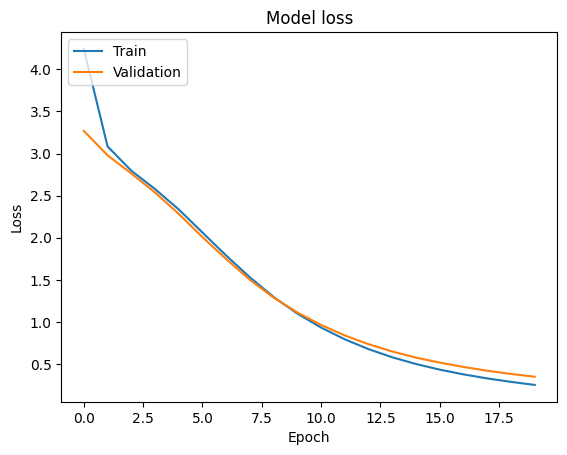

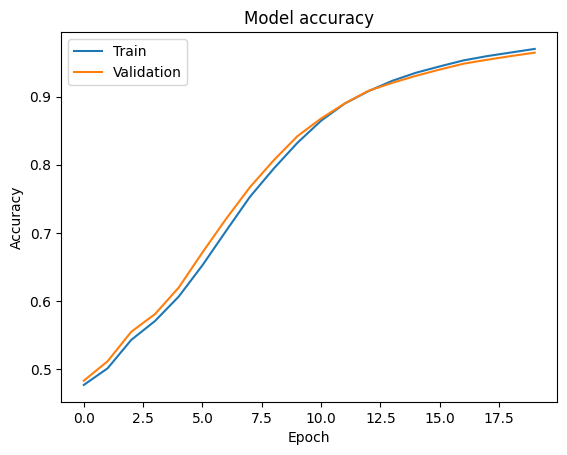

In [74]:
import matplotlib.pyplot as plt

# Assuming you have already imported your model and data

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
model.save_weights("translation_model_weights.h5")

In [75]:
model.save_weights("translation_model_weights.h5")

In [24]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import math

models = Model([encoder_inputs, decoder_inputs], decoder_outputs)
models.load_weights("translation_model_weights.h5")


In [ ]:
# Define the learning rate
initial_learning_rate = 0.05
decay_rate = 0.9
decay_steps = 1000
def exponential_decay(epoch, lr):
    return lr * decay_rate ** (epoch / decay_steps)
# Create an instance of the Adam optimizer with custom learning rate
adam_optimizer = Adam(learning_rate=initial_learning_rate)

# Compile the model with the custom optimizer
models.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lr_scheduler = LearningRateScheduler(exponential_decay, verbose=1)

# Fit the model with the learning rate scheduler callback
history = models.fit([X_train, X_train], y_train, epochs=10, batch_size=128, callbacks=[lr_scheduler])

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
models.save_weights("translations_model_weights.h5")

In [ ]:
models.save_weights("translations_model_weights.h5")

In [ ]:
pip install editdistance

In [43]:
import numpy as np
import editdistance  # Install using: pip install editdistance

# Assuming you have your predictions in 'predictions' and ground truth in 'y_test'
# predictions = ...
# y_test = ...

# Convert numerical representations back to tokens
def indices_to_words(indices, tokenizer):
    return [tokenizer.index_word[index] for index in indices if index != 0]  # Exclude padding token

# Convert predictions and y_test into lists of strings
predicted_sentences = [" ".join(indices_to_words(sentence, tokenizer_target)) for sentence in np.argmax(predictions, axis=2)]
reference_sentences = [" ".join(indices_to_words(sentence, tokenizer_target)) for sentence in y_test]

# Calculate Levenshtein distance for each pair of sentences
edit_distances = [editdistance.eval(reference, predicted) for reference, predicted in zip(reference_sentences, predicted_sentences)]

# Average Levenshtein distance over all sentences
average_edit_distance = np.mean(edit_distances)

print("Average Levenshtein Distance:", average_edit_distance)


Average Levenshtein Distance: 1.3668651637601021
